Year 2021: 186 abstracts loaded
Year 2022: 233 abstracts loaded
Year 2023: 318 abstracts loaded
Year 2024: 279 abstracts loaded
Total filtered terms: 929
Filtered terms: ['leverages', 'led', 'entity', 'art', 'external', 'spanish', 'features', '6th', 'task shared', 'dataset']
Year 2021: 764 terms
Terms: [('10', 1), ('11', 1), ('12', 1), ('14', 1), ('16', 1), ('1st', 1), ('20', 1), ('22', 1), ('2nd', 1), ('3rd', 1)]
Year 2022: 843 terms
Terms: [('10', 1), ('10th', 1), ('11', 1), ('11th', 1), ('12', 1), ('14', 1), ('16', 1), ('1st', 1), ('22', 1), ('25', 1)]
Year 2023: 893 terms
Terms: [('10', 1), ('10th', 1), ('11', 1), ('11th', 1), ('12', 1), ('14', 1), ('16', 1), ('1st', 1), ('20', 1), ('22', 1)]
Year 2024: 841 terms
Terms: [('10', 1), ('10th', 1), ('11th', 1), ('12', 1), ('14', 1), ('1st', 1), ('20', 1), ('22', 1), ('25', 1), ('2nd', 1)]
Total trends: 929
Sample trends: [('leverages', [(2022, 0), (2023, 0), (2024, 0)]), ('led', [(2022, -1), (2023, 1), (2024, 0)]), ('entity', [(2022, 0

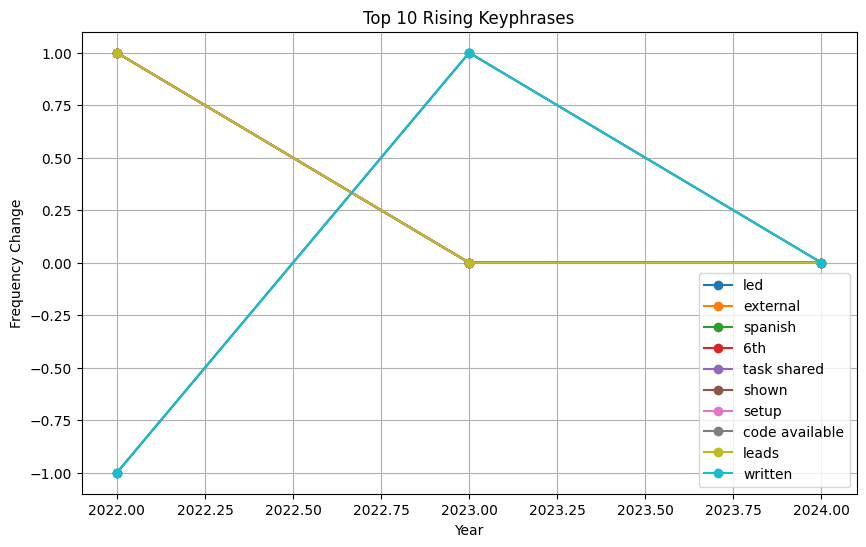

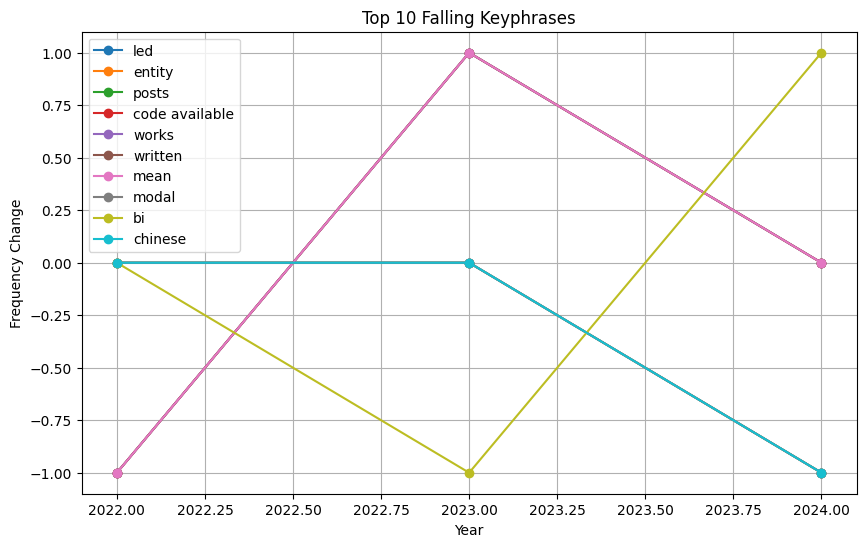

In [21]:
import json
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Define the files and their associated years
file_year_mapping = {
    "papers-semeval-2021.json": 2021,
    "papers-semeval-2022.json": 2022,
    "papers-semeval-2023.json": 2023,
    "papers-semeval-2024.json": 2024,
}

# Load stopwords from stopwords.txt
with open("stopwords.txt", "r", encoding="utf-8") as f:
    file_stopwords = set(line.strip().lower() for line in f)

# Group abstracts by year
abstracts_by_year = defaultdict(list)
for file, year in file_year_mapping.items():
    with open(file, "r", encoding="utf-8") as f:
        papers = json.load(f)
        abstracts = [paper["abstract"] for paper in papers if paper.get("abstract")]
        abstracts_by_year[year] = abstracts

# Verify loaded abstracts
for year, abstracts in abstracts_by_year.items():
    print(f"Year {year}: {len(abstracts)} abstracts loaded")

# Dynamic stopwords to exclude overly common terms
def generate_dynamic_stopwords(abstracts_by_year):
    term_frequencies = defaultdict(int)
    total_abstracts = sum(len(abstracts) for abstracts in abstracts_by_year.values())
    for abstracts in abstracts_by_year.values():
        for abstract in abstracts:
            for term in set(re.findall(r'\b[a-zA-Z][a-zA-Z]+\b', abstract.lower())):
                term_frequencies[term] += 1

    # Terms that appear in more than 80% of abstracts are treated as stopwords
    dynamic_stopwords = {term for term, freq in term_frequencies.items() if freq / total_abstracts > 0.8}
    return dynamic_stopwords

# Combine static and dynamic stopwords
dynamic_stopwords = generate_dynamic_stopwords(abstracts_by_year)
all_stopwords = file_stopwords | dynamic_stopwords

# Keyphrase extraction
def extract_keyphrases(abstracts):
    vectorizer = TfidfVectorizer(
        stop_words='english',  
        max_df=0.85,  # Ignore overly frequent terms
        min_df=3,     # Include terms in at least 3 documents
        ngram_range=(1, 2)  # Unigrams and bigrams
    )
    tfidf_matrix = vectorizer.fit_transform(abstracts)
    terms = vectorizer.get_feature_names_out()
    return terms

# Calculate term frequencies
freq_by_year = defaultdict(dict)
for year, abstracts in abstracts_by_year.items():
    terms = extract_keyphrases(abstracts)
    term_counts = defaultdict(int)
    for term in terms:
        term_counts[term] += 1
    freq_by_year[year] = term_counts

# Filter out low-frequency terms
min_total_frequency = 3
global_term_counts = defaultdict(int)
for year, term_freqs in freq_by_year.items():
    for term, count in term_freqs.items():
        global_term_counts[term] += count

filtered_terms = {term for term, count in global_term_counts.items() if count >= min_total_frequency}
print(f"Total filtered terms: {len(filtered_terms)}")
print(f"Filtered terms: {list(filtered_terms)[:10]}")

for year, term_freqs in freq_by_year.items():
    freq_by_year[year] = {term: count for term, count in term_freqs.items() if term in filtered_terms}
    print(f"Year {year}: {len(freq_by_year[year])} terms")
    print(f"Terms: {list(freq_by_year[year].items())[:10]}")

# Calculate trends based on term frequency differences
trends = defaultdict(list)
years = sorted(freq_by_year.keys())
for term in filtered_terms:
    if sum(term in freq_by_year[year] for year in years) > 1:  # Ensure term appears in >1 year
        for i in range(len(years) - 1):
            year1, year2 = years[i], years[i + 1]
            freq_diff = freq_by_year[year2].get(term, 0) - freq_by_year[year1].get(term, 0)
            trends[term].append((year2, freq_diff))

print(f"Total trends: {len(trends)}")
print(f"Sample trends: {list(trends.items())[:10]}")


# Identify rising and falling phrases
def identify_trends(trends, top_n=10):
    rising = sorted(
        trends.items(),
        key=lambda x: max(change[1] for change in x[1]),
        reverse=True
    )[:top_n]
    falling = sorted(
        trends.items(),
        key=lambda x: min(change[1] for change in x[1])
    )[:top_n]

    # Extract phrase names
    rising_phrases = [phrase for phrase, _ in rising]
    falling_phrases = [phrase for phrase, _ in falling]

    return rising_phrases, falling_phrases

rising_phrases, falling_phrases = identify_trends(trends)

# Plot the trends
def plot_trends(phrases, trends, title):
    if not phrases:
        print(f"No trends to display for {title}.")
        return
    plt.figure(figsize=(10, 6))
    for phrase in phrases:
        changes = trends.get(phrase, [])
        if changes:
            years, values = zip(*changes)
            plt.plot(years, values, marker='o', label=phrase)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Frequency Change")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Debug and visualize
print("Rising Phrases:", rising_phrases)
print("Falling Phrases:", falling_phrases)
plot_trends(rising_phrases, trends, "Top 10 Rising Keyphrases")
plot_trends(falling_phrases, trends, "Top 10 Falling Keyphrases")


Year 2021: 2790 keyphrases extracted
Year 2022: 3495 keyphrases extracted
Year 2023: 4770 keyphrases extracted
Year 2024: 4171 keyphrases extracted


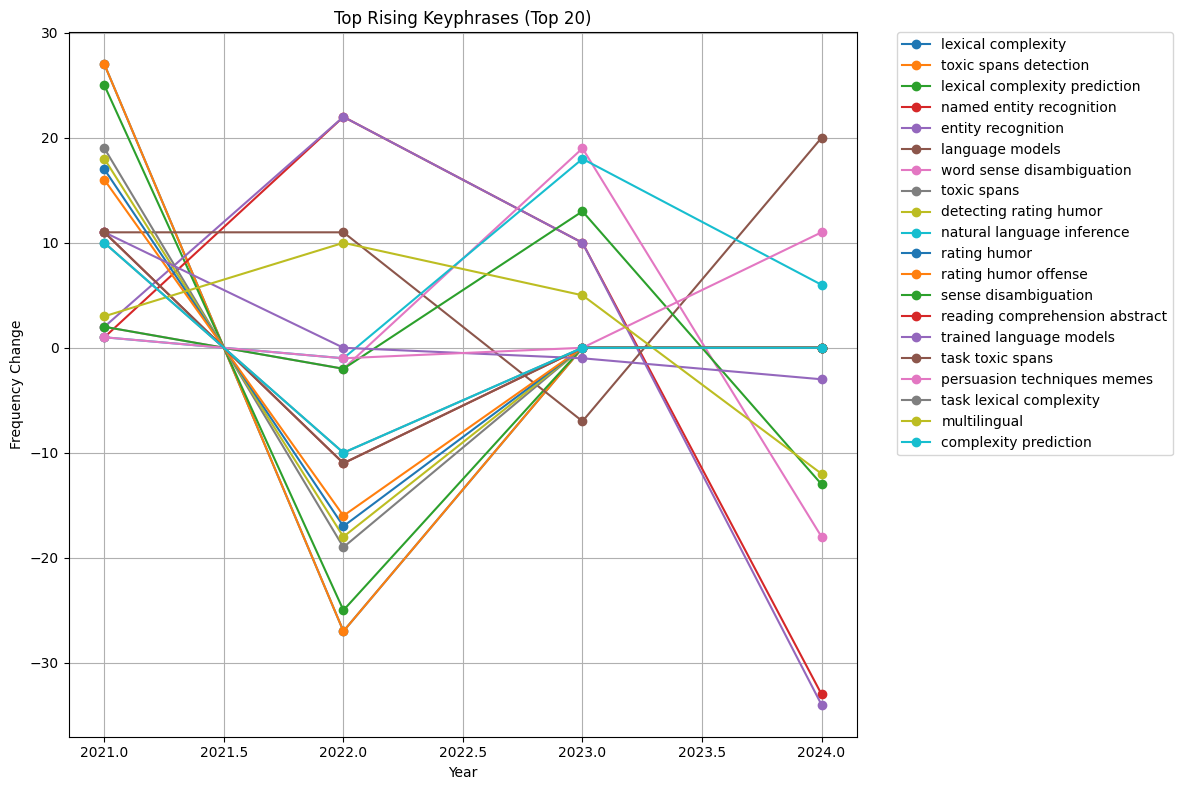

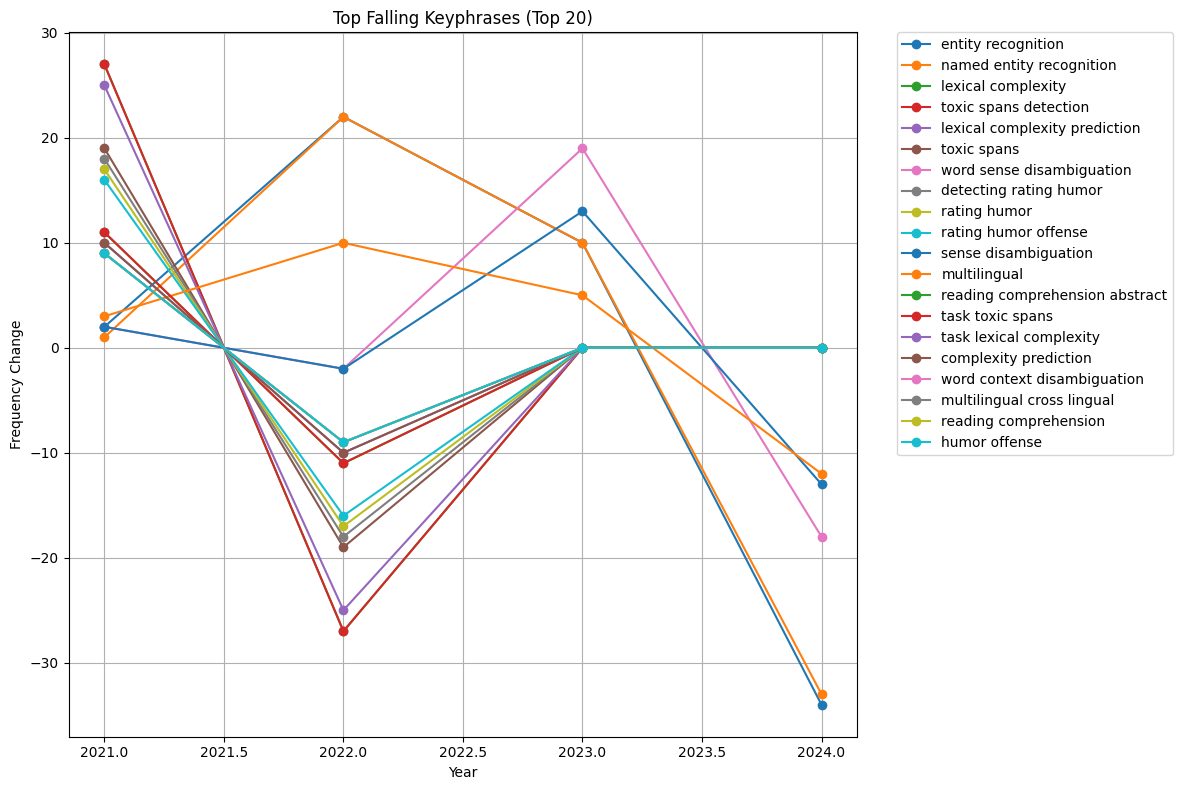

In [28]:
from keybert import KeyBERT
import json
import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize KeyBERT
kw_model = KeyBERT()

# Define the files and their associated years
file_year_mapping = {
    "papers-semeval-2021.json": 2021,
    "papers-semeval-2022.json": 2022,
    "papers-semeval-2023.json": 2023,
    "papers-semeval-2024.json": 2024,
}

# Load abstracts by year
abstracts_by_year = defaultdict(list)
for file, year in file_year_mapping.items():
    with open(file, "r", encoding="utf-8") as f:
        papers = json.load(f)
        abstracts = [paper["abstract"] for paper in papers if paper.get("abstract")]
        abstracts_by_year[year] = abstracts

# Extract keyphrases with KeyBERT
def extract_keyphrases_with_keybert(abstracts, top_n=15):
    all_phrases = []
    for abstract in abstracts:
        keyphrases = kw_model.extract_keywords(abstract, keyphrase_ngram_range=(1, 3), top_n=top_n)
        all_phrases.extend([phrase for phrase, _ in keyphrases])
    return all_phrases

# Extract keyphrases per year
keyphrases_by_year = defaultdict(list)
for year, abstracts in abstracts_by_year.items():
    keyphrases = extract_keyphrases_with_keybert(abstracts)
    keyphrases_by_year[year] = keyphrases
    print(f"Year {year}: {len(keyphrases)} keyphrases extracted")

# Calculate term frequency per year
freq_by_year = defaultdict(dict)
for year, keyphrases in keyphrases_by_year.items():
    for phrase in keyphrases:
        freq_by_year[year][phrase] = freq_by_year[year].get(phrase, 0) + 1

# Calculate trends based on frequency differences
trends = defaultdict(list)
years = sorted(freq_by_year.keys())
for term in freq_by_year[years[0]].keys():
    for i in range(len(years) - 1):
        year1, year2 = years[i], years[i + 1]
        freq_diff = freq_by_year[year2].get(term, 0) - freq_by_year[year1].get(term, 0)
        trends[term].append((year2, freq_diff))

# Identify rising and falling phrases
def identify_trends(trends, top_n=10):
    rising = sorted(
        trends.items(),
        key=lambda x: max(change[1] for change in x[1]),
        reverse=True
    )[:top_n]
    falling = sorted(
        trends.items(),
        key=lambda x: min(change[1] for change in x[1])
    )[:top_n]

    # Extract phrase names
    rising_phrases = [phrase for phrase, _ in rising]
    falling_phrases = [phrase for phrase, _ in falling]

    return rising_phrases, falling_phrases

rising_phrases, falling_phrases = identify_trends(trends)

# Function to calculate trends with 2021 as the baseline
def calculate_trends(freq_by_year):
    trends = defaultdict(list)
    years = sorted(freq_by_year.keys())
    
    for term in freq_by_year[years[0]].keys():
        # Include the 2021 frequency as the baseline
        baseline_year = years[0]
        trends[term].append((baseline_year, freq_by_year[baseline_year].get(term, 0)))
        
        # Calculate changes for subsequent years
        for i in range(len(years) - 1):
            year1, year2 = years[i], years[i + 1]
            freq_diff = freq_by_year[year2].get(term, 0) - freq_by_year[year1].get(term, 0)
            trends[term].append((year2, freq_diff))
    
    return trends

# Recalculate trends
trends = calculate_trends(freq_by_year)

# Plot separate rising and falling trends
def plot_rising_and_falling(trends, title, top_n=20, rising=True):
    sorted_trends = sorted(
        trends.items(),
        key=lambda x: max(change[1] if rising else -change[1] for change in x[1]),
        reverse=True
    )
    top_phrases = [phrase for phrase, _ in sorted_trends[:top_n]]

    plt.figure(figsize=(12, 8))
    for phrase in top_phrases:
        changes = trends.get(phrase, [])
        if changes:
            years, values = zip(*changes)
            # Ensure all years (2021 to 2024) are represented
            all_years = [2021, 2022, 2023, 2024]
            all_values = [0] * len(all_years)
            for year, value in changes:
                all_values[all_years.index(year)] = value
            plt.plot(all_years, all_values, marker='o', label=phrase)
    plt.title(f"{title} (Top {top_n})")
    plt.xlabel("Year")
    plt.ylabel("Frequency Change")
    plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot top rising and falling trends separately
plot_rising_and_falling(trends, "Top Rising Keyphrases", top_n=20, rising=True)
plot_rising_and_falling(trends, "Top Falling Keyphrases", top_n=20, rising=False)



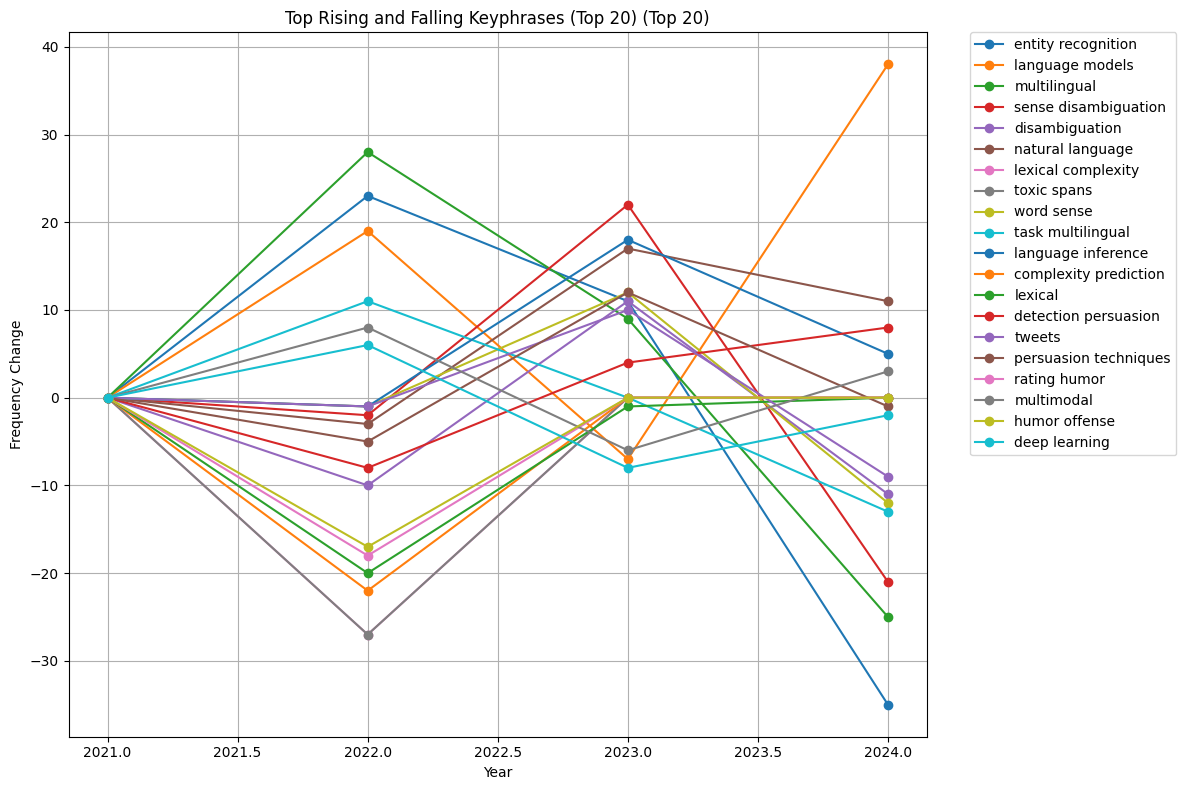

In [24]:
# Plot trends for a larger number of phrases directly from the trends dictionary
def plot_extended_trends(trends, title, top_n=20):
    # Sort phrases by the total frequency change (sum of absolute differences across years)
    sorted_trends = sorted(
        trends.items(),
        key=lambda x: sum(abs(change[1]) for change in x[1]),
        reverse=True
    )
    
    # Extract the top_n phrases for plotting
    top_phrases = [phrase for phrase, _ in sorted_trends[:top_n]]
    
    # Plot the trends
    plt.figure(figsize=(12, 8))
    for phrase in top_phrases:
        changes = trends.get(phrase, [])
        if changes:
            # Include all 4 years in the x-axis
            years, values = zip(*changes)
            all_years = [2021, 2022, 2023, 2024]
            all_values = [0] * len(all_years)
            for year, value in changes:
                all_values[all_years.index(year)] = value
            plt.plot(all_years, all_values, marker='o', label=phrase)
    plt.title(f"{title} (Top {top_n})")
    plt.xlabel("Year")
    plt.ylabel("Frequency Change")
    plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot extended trends for rising and falling phrases
plot_extended_trends(trends, "Top Rising and Falling Keyphrases (Top 20)", top_n=20)
